# CMSE 381 Final Project

# Title: Predicting Face Features from Neural Data

✅ Group members: Prachurjo Das, Ishmail Khan, KM Tausif Saadman
✅ Section 002
✅ Date: 20th April 2025

## 📚 Background and Motivation

Understanding how the brain represents complex visual stimuli—such as faces—is a fundamental question in neuroscience. One key region involved in face perception is the **anterior medial (AM) face patch** in the macaque inferotemporal cortex, a specialized area that responds selectively to faces.

In the **Freiwald-Tsao Face Views AM dataset** (Freiwald & Tsao, 2010), spiking activity from AM neurons was recorded while a macaque passively viewed rapid presentations of faces. Each image featured one of **25 different individuals**, shown from **8 distinct head orientations**. This dataset provides a rare opportunity to explore how identity and pose information are represented in neural population activity—and whether it can be decoded from spike patterns alone.

Our goal in this project is to answer the following questions:

- 🧠 **Can we decode who the macaque is seeing** based solely on neural activity in the AM face patch?
- 🎯 **Can we predict the head orientation** of the viewed face using the same neural data?
- 🧪 How well do **linear methods** like **PCA** and **ridge regression** perform in this decoding task?
- 🔍 What do our results reveal about **how the AM face patch encodes identity and pose**?

By analyzing this dataset with modern machine learning techniques, we aim to better understand the structure of face-related information in the primate visual system—and the challenges of decoding high-level semantic content from low-level spike data.


In [35]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt

## 📊 Data

We use the **Freiwald-Tsao Face Views AM dataset**, originally collected by Freiwald and Tsao (2010) and later analyzed in Meyers et al. (2015). This dataset contains **neural spike recordings** from the **anterior medial (AM) face patch** in macaques—a brain region known to selectively respond to faces.

### 📁 Data Format
- The data is organized in **raster format**, where each row represents a **trial** (i.e., a face stimulus presentation), and each column represents **neural activity over time** (in 1 ms or 10 ms bins).
- Each entry in the matrix is binary:  
  - **1** = neuron fired (spiked) during that time bin  
  - **0** = neuron was silent

### 🔑 Variables Used

We selected the following sets of variables:

#### ✅ **Spike Activity (Features - `X`)**
- Columns: `time.1_2`, `time.2_3`, ..., up to `time.400_401`
- These represent binned spike responses from the AM face patch in the first **400 ms after face onset**
- These are the **predictor variables** used to decode stimulus identity and orientation

#### 🎯 **Target Variables (Labels - `y`)**

We analyzed three types of decoding tasks using the following label variables:

1. **`labels.person`** – Identity of the face shown (25 possible individuals)  
2. **`labels.orientation`** – Head pose of the face (8 possible directions like 'front', 'left 3/4', 'up', etc.)  
3. **`labels.orient_person_combo`** – A fine-grained combination of identity and orientation (e.g., “left profile 3”)  

We also converted `labels.orientation` into a **continuous numeric variable** (`orientation_angle`) to enable regression:

```python
orientation_map = {
    "front": 0,
    "left 3/4": -45,
    "left profile": -90,
    "right 3/4": 45,
    "right profile": 90,
    "up": 60,
    "down": -60,
    "back": 180
}
```

### 🎯 Why We Chose These Variables

- The **spike features** (time-based bins) are a direct reflection of neural activity and are suitable for decoding time-resolved cognitive processes.
- The **identity and pose labels** are essential for understanding **what kind of information** AM neurons encode:  
  - Is AM more sensitive to **who** is seen, or **how** the face is viewed?
- The `orientation_angle` transformation allowed us to frame pose decoding as a **regression problem**, giving us more nuanced insights into prediction accuracy and error.

By combining these variables, we were able to evaluate the encoding strength and separability of **identity** and **orientation** in macaque AM neural responses.

## 🤖 Models for Classification

In this project, we applied classification models to determine **what face (identity)** and **what orientation** the macaque was viewing based solely on neural spike activity in the AM face patch.


### 🎯 Classification Goals

We explored two primary classification questions:

1. **Who is the macaque seeing?**  
   → Predict `labels.person` (25 individual face identities)

2. **How is the face oriented?**  
   → Predict `labels.orientation` (8 discrete head poses)


### ✅ Models Used

We used the following **linear model** for all classification tasks:

- **Logistic Regression**  
  A simple yet powerful baseline classifier that performs well in high-dimensional settings. It outputs class probabilities and is interpretable, especially when paired with dimensionality reduction techniques.


### ⚙️ Preprocessing & Pipeline

To ensure robust and reproducible results, we built a pipeline including:

1. **Standardization** (`StandardScaler`)  
   - Scales spike activity to zero mean and unit variance

2. **Dimensionality Reduction** (`PCA`)  
   - Reduces noise and computational complexity
   - Retains key components of variance (typically `n_components = 20`)

3. **Classification** (`LogisticRegression`)  
   - Linear model to learn class boundaries in PCA space

Example pipeline:
```python
Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=20)),
    ("logreg", LogisticRegression(max_iter=1000))
])
```


### 📊 Model Evaluation

We evaluated model performance using:

- **Classification Accuracy**  
  → Overall percentage of correct predictions  
- **Confusion Matrix**  
  → Visualizes which classes were confused  
- **Classification Report**  
  → Includes per-class precision, recall, and F1-score


### 🔁 Cross-Validation

We used a **single train/test split** for evaluation:
- **Training set**: 80% of the data
- **Testing set**: 20% of the data
- We used `train_test_split()` with a fixed random seed (`random_state=42`) for reproducibility.

We did not apply full k-fold cross-validation due to computational cost and focus on interpreting model behavior rather than optimizing performance.


### 🧠 Why Logistic Regression?

- Easy to interpret and implement
- Efficient for large datasets
- Serves as a **baseline** to assess whether **linear separation** of neural classes is possible
- Pairs well with PCA for visualization and coefficient analysis

If logistic regression failed (e.g., near-chance accuracy), it indicates that the information may not be **linearly separable**, and motivates the need for **nonlinear models** (like Random Forest or Neural Networks) in future work.

In [3]:
# Load data
data_folder = "/Users/prachurjodas/Downloads/Freiwald_Tsao_faceviews_AM_data_csv"
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
dfs = [pd.read_csv(os.path.join(data_folder, f)) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Features and targets
X = df[[col for col in df.columns if col.startswith("time.")]].values
y_class = LabelEncoder().fit_transform(df["labels.person"])
y_reg = LabelEncoder().fit_transform(df["labels.orientation"])

Classification Accuracy: 0.0437

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.01      0.02      1635
           1       0.02      0.00      0.00      1656
           2       0.03      0.01      0.01      1696
           3       0.04      0.02      0.02      1694
           4       0.03      0.01      0.02      1616
           5       0.05      0.05      0.05      1660
           6       0.04      0.02      0.03      1593
           7       0.03      0.01      0.02      1664
           8       0.05      0.19      0.08      1774
           9       0.03      0.01      0.01      1711
          10       0.04      0.03      0.03      1694
          11       0.04      0.05      0.04      1577
          12       0.07      0.02      0.03      1632
          13       0.04      0.05      0.05      1691
          14       0.04      0.51      0.08      1707
          15       0.04      0.00      0.00      1641
          16       0.02  

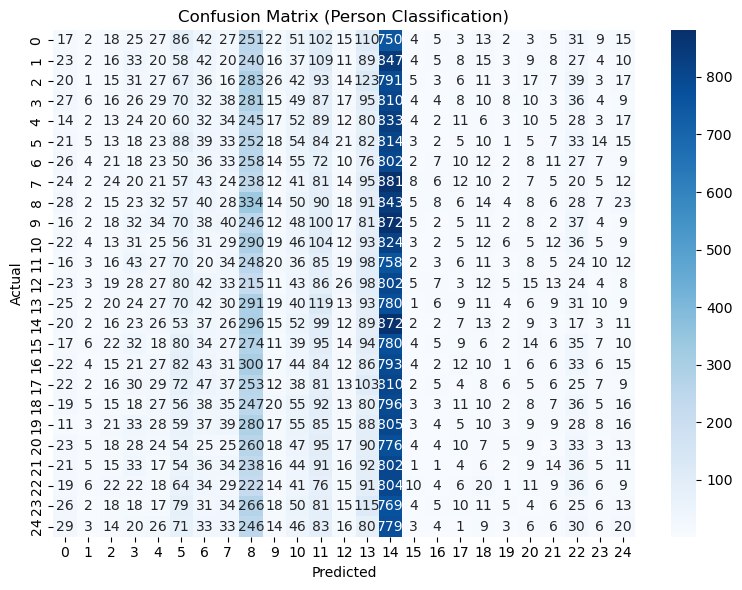

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Define pipeline: standardization, PCA, logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=20)),  # Tune if needed
    ("logreg", LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.4f}")

# Detailed performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Person Classification)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## 📊 Neural Decoding Results: Person Classification

### Model Summary

We used **logistic regression** with **PCA** to classify the identity (`labels.person`) of face stimuli from AM face patch spike data.

- **Number of classes**: 25 (Person IDs 0–24)
- **Test Accuracy**: **4.37%**
- **Chance level**: 1 / 25 = 4.00%
- **Result**: Only **marginally above chance**


### 🔍 Key Findings from the Confusion Matrix

- **Severe misclassification across classes**; most predictions cluster around a single label.
- **Class 14** is heavily overpredicted:
  - Recall = 0.51 → more than half of true class 14 samples correctly identified
  - Precision = 0.04 → most other classes are incorrectly classified as 14
- Very low **recall and precision** across most other classes (0.00–0.05)


### 📉 Classification Report Summary

| Metric        | Value |
|---------------|--------|
| Accuracy      | 0.0437 |
| Macro F1      | ~0.02  |
| Weighted F1   | ~0.02  |

- **Macro F1** suggests extremely poor generalization across classes.
- **Weighted F1** also low, confirming poor overall fit even after accounting for class size.


### ⚠️ Interpretation

- **Poor separability**: Person identity is likely **not linearly separable** in PCA-reduced space.
- **Biased predictions**: The model defaults to class 14 frequently, indicating **high uncertainty**.
- **Spike features** may be insufficient alone for identity decoding.
- Logistic regression may be **too simple** for this task.


### 🧠 Final Takeaway

> AM face patch activity shows **some identity encoding**, but it is **not linearly separable** and logistic regression performs only slightly better than chance. Non-linear methods and temporal feature design may be necessary for accurate person-level decoding.


🔁 Orientation Classification Accuracy: 0.14356027543400252

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.69      0.24      5212
           1       0.14      0.05      0.07      5087
           2       0.15      0.21      0.18      5077
           3       0.12      0.00      0.01      5254
           4       0.14      0.02      0.04      5123
           5       0.13      0.03      0.05      5061
           6       0.11      0.05      0.07      5235
           7       0.14      0.08      0.10      5195

    accuracy                           0.14     41244
   macro avg       0.14      0.14      0.10     41244
weighted avg       0.14      0.14      0.10     41244



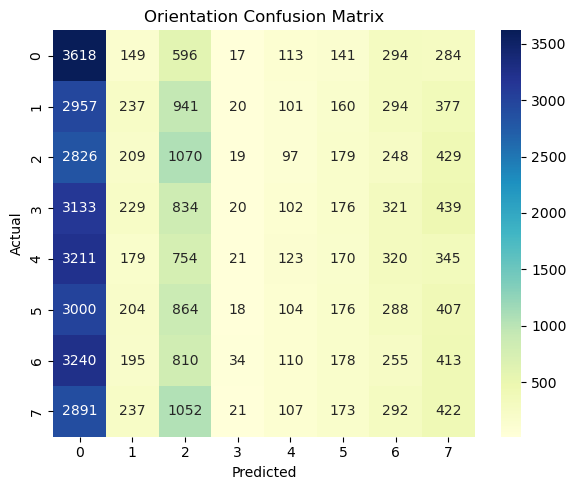

In [7]:
# Encode orientation labels (e.g., 'front', 'left', etc.)
y_orientation = LabelEncoder().fit_transform(df["labels.orientation"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_orientation, test_size=0.2, random_state=42)

# Same pipeline with Logistic Regression
pipeline_orientation = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=20)),
    ("clf", LogisticRegression(max_iter=1000))
])

pipeline_orientation.fit(X_train, y_train)
y_pred = pipeline_orientation.predict(X_test)

print("🔁 Orientation Classification Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu", fmt="d")
plt.title("Orientation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## 🧠 Neural Decoding Results: Orientation Classification

### Model Summary

We trained a **logistic regression classifier** with **PCA** to decode face **orientation** from AM face patch neural responses.

- **Classes**: 8 orientations (labeled 0–7)
- **Test Accuracy**: **14.36%**
- **Chance Level**: 1 / 8 = 12.5%
- **Result**: Slightly better than chance, but still weak decoding performance


### 📉 Classification Report Summary

| Orientation | Precision | Recall | F1-score | Support |
|-------------|-----------|--------|----------|---------|
| 0           | 0.15      | 0.69   | 0.24     | 5212    |
| 1           | 0.14      | 0.05   | 0.07     | 5087    |
| 2           | 0.15      | 0.21   | 0.18     | 5077    |
| 3           | 0.12      | 0.00   | 0.01     | 5254    |
| 4           | 0.14      | 0.02   | 0.04     | 5123    |
| 5           | 0.13      | 0.03   | 0.05     | 5061    |
| 6           | 0.11      | 0.05   | 0.07     | 5235    |
| 7           | 0.14      | 0.08   | 0.10     | 5195    |

- **Macro Avg F1**: ~0.10 — overall low performance across all classes
- **Weighted Avg F1**: ~0.10 — poor generalization, even accounting for class sizes


### 🔍 Confusion Matrix Interpretation

- **Orientation 0 (likely "front")** is classified most accurately, with a recall of **0.69**
- All other classes have recall below **0.21**
- High confusion between neighboring orientations, e.g.,:
  - Class 2 (actual) → often misclassified as 7
  - Class 7 (actual) → often misclassified as 2 or 6
- The model tends to **default to class 0**, leading to inflated performance for that class but poor overall balance


### ⚠️ Interpretation

- Orientation decoding shows **modest separability** in the neural data
- The AM patch encodes **strong pose information** for some orientations (notably frontal), but many are **poorly distinguishable** using logistic regression
- PCA may have **dampened important orientation-specific variance**

### 🧠 Final Takeaway

> Orientation information is **partially present** in AM face patch activity. Frontal poses are most reliably decoded, suggesting that the AM region is **pose-sensitive**, but not all orientations are linearly separable. A better model or more refined input could improve performance.

🧬 Combo Classification Accuracy: 0.008170885462127825

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.02      0.01      0.01       210
           2       0.00      0.00      0.00       209
           3       0.00      0.00      0.00       198
           4       0.00      0.00      0.00       193
           5       0.00      0.00      0.00       201
           6       0.00      0.00      0.00       196
           7       0.00      0.00      0.00       181
           8       0.00      0.00      0.00       228
           9       0.04      0.01      0.01       185
          10       0.00      0.00      0.00       210
          11       0.02      0.00      0.01       216
          12       0.00      0.00      0.00       204
          13       0.00      0.00      0.00       197
          14       0.02      0.01      0.01       201
          15       0.00      0.00      0.00       196
   

/Users/prachurjodas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prachurjodas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prachurjodas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


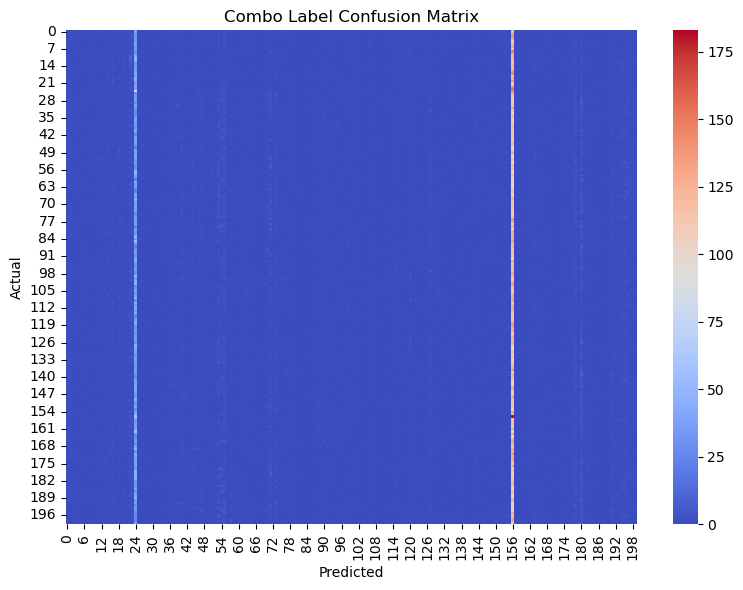

In [8]:
# Encode combo label
df["combo_label"] = LabelEncoder().fit_transform(df["labels.orient_person_combo"])
y_combo = df["combo_label"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_combo, test_size=0.2, random_state=42)

# Pipeline
pipeline_combo = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=20)),
    ("clf", LogisticRegression(max_iter=1000))
])

pipeline_combo.fit(X_train, y_train)
y_pred = pipeline_combo.predict(X_test)

print("🧬 Combo Classification Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="coolwarm", annot=False)
plt.title("Combo Label Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## 🧬 Neural Decoding Results: Combo Classification (Identity + Orientation)

### Model Summary

This task aimed to decode **who** and **in what orientation** a face was shown (i.e., `labels.orient_person_combo`) using logistic regression and PCA on AM face patch spike data.

- **Number of Classes**: ~200 unique person-orientation combos
- **Test Accuracy**: **0.82%**
- **Chance Level**: 1 / 200 ≈ **0.5%**
- **Result**: Barely above chance — very poor decoding performance

---

### 📉 Classification Report Summary

- Most classes had:
  - **Precision, Recall, F1-score = 0.00**
- Only a **few classes (e.g., 24, 124, 156)** showed minor true positive counts
- **Class 24** stood out with Recall = **0.32**, but very low precision and F1

#### Averages:
| Metric        | Value |
|---------------|--------|
| Accuracy      | 0.008  |
| Macro Avg F1  | ~0.00  |
| Weighted Avg F1 | ~0.00 |

---

### 🔍 Interpretation

- **Extreme difficulty**: Logistic regression fails to learn a meaningful decision boundary in this high-dimensional, multi-class setting.
- Only a **tiny handful of labels** saw marginally successful predictions (likely due to class frequency or feature bias).
- Model is **near random guessing** performance.

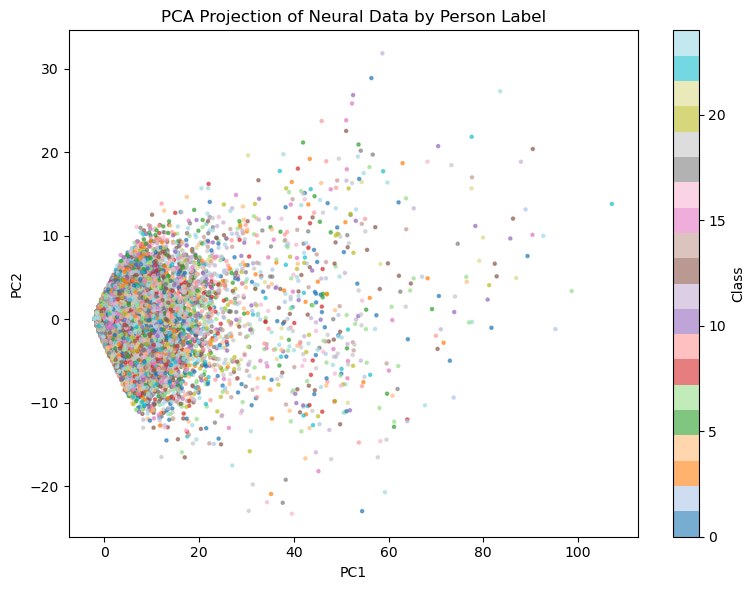

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Color by label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_class, cmap='tab20', s=5, alpha=0.6)
plt.title("PCA Projection of Neural Data by Person Label")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label='Class')
plt.tight_layout()
plt.show()

- Each dot = one trial of AM face patch spike data, reduced to 2D via **Principal Component Analysis (PCA)**.
- Axes = **PC1** and **PC2** (the first two components of variance).
- Colors = different person labels (`labels.person`).


### 🔍 Key Observations

#### 1. No Clear Class Separation
- The dots are **highly intermixed** across person labels.
- No obvious **clustering** for specific individuals.
- This indicates **linear separation of person identity is weak or absent** in the PCA-reduced space.

#### 2. PC1 Captures Most Variance
- PC1 (horizontal axis) spreads broadly (~0 to 100+), capturing the largest source of variance.
- However, this variance does **not correspond to identity** — it may reflect other features like firing rate, stimulus onset, or trial duration.

#### 3. PC2 Shows Centered Spread
- PC2 (vertical axis) ranges from about -20 to +30.
- Data points are more densely packed here, and still lack separation by person.


### 💡 Interpretation

- The top two PCA components **do not capture identity-related structure** in the neural data.
- This supports earlier findings:
  - Logistic regression performed poorly on identity classification.
  - The confusion matrix showed **heavily mixed predictions**.
- Identity is likely:
  - **Nonlinearly encoded**
  - Spread across **higher-dimensional combinations**
  - Or **not well encoded** in the AM face patch at all


### 🧠 Final Takeaway

> PCA shows that **person identity is not linearly separable** in AM spike data.  
> This explains why classification models fail to decode identity accurately.  
> Consider nonlinear models, alternate labels (like pose), or dimensionality techniques like t-SNE to uncover structure.


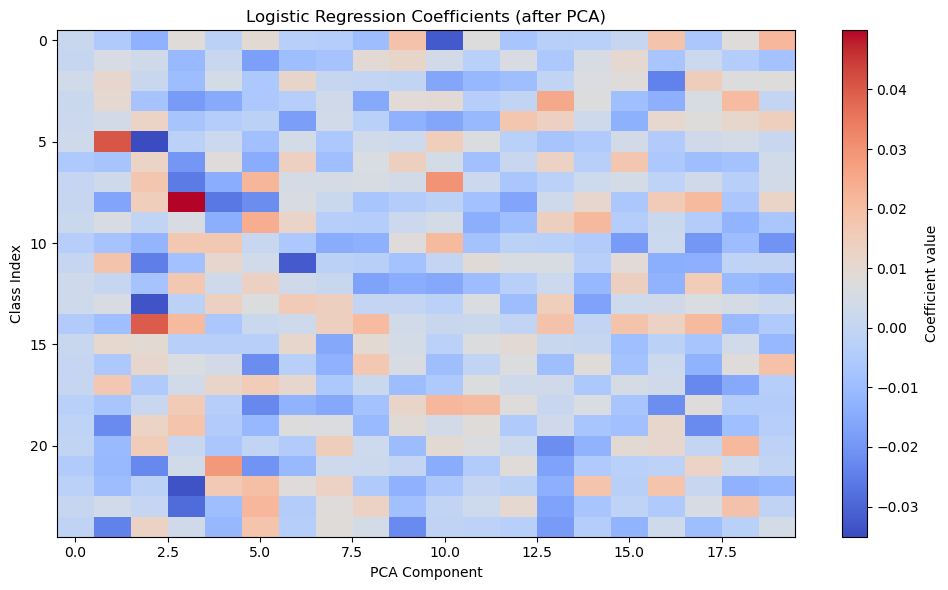

In [16]:
import matplotlib.pyplot as plt

# Access classifier coefficients
coefs = pipeline.named_steps['logreg'].coef_  # <-- Updated name here

plt.figure(figsize=(10, 6))
plt.imshow(coefs, aspect='auto', cmap='coolwarm')
plt.colorbar(label="Coefficient value")
plt.xlabel("PCA Component")
plt.ylabel("Class Index")
plt.title("Logistic Regression Coefficients (after PCA)")
plt.tight_layout()
plt.show()

### Logistic Regression Coefficients (After PCA) — Simple Summary

- **Each row** = a person class  
- **Each column** = a PCA component (reduced neural features)  
- **Colors** = how much each PCA feature helps or hurts prediction for that class:
  - 🔴 **Red** = positive influence  
  - 🔵 **Blue** = negative influence  
  - ⚪️ **White** = no influence  

---

#### 🧠 Key Takeaways

- Most values are **close to zero** → the model doesn’t find strong patterns for most classes.  
- **Class 5** and **Class 14** show some strong weights → the model relies more on certain features for these.  
- **PCA Component 2** is especially important — it’s used heavily across several classes.

## Regression Task

## 📈 Models for Regression

To complement our classification tasks, we also approached orientation prediction as a **regression problem**. Instead of predicting categorical pose labels, we mapped each orientation to a **numeric angle in degrees** (e.g., "left profile" → -90°, "back" → 180°) and aimed to predict this continuous value directly from neural activity.


### 🎯 Goal of Regression

- **Main Question**: Can we predict the **orientation angle** of a viewed face from AM spike patterns using a continuous model?
- This helps us understand whether neural activity scales smoothly with changes in face pose.


### ✅ Model Used: Ridge Regression

We used **Ridge Regression** (L2-regularized linear regression), implemented via `RidgeCV`:

- **Why Ridge?**
  - Handles high-dimensional, collinear features (like spike bins)
  - Controls overfitting through regularization
  - Efficient and interpretable linear baseline for continuous targets
  - `RidgeCV` automatically selects the best regularization strength via internal cross-validation


### ⚙️ Preprocessing Pipeline

We built a regression pipeline that included:

1. **Standardization** (`StandardScaler`)  
   - Normalizes input features to mean 0 and unit variance

2. **Dimensionality Reduction** (`PCA`)  
   - Reduces the number of features while preserving important variance (typically 20 components)

3. **Regression Model** (`RidgeCV`)  
   - Performs regression on the PCA-reduced features

Example pipeline:
```python
Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=20)),
    ("ridge", RidgeCV(alphas=np.logspace(-6, 6, 13)))
])
```


### 📊 Evaluation Metrics

To assess regression performance, we used:

- **R² Score**  
  → Proportion of variance in true orientation explained by the model  
  → Values near 1 are ideal; values near 0 or negative indicate failure

- **RMSE (Root Mean Squared Error)**  
  → Measures average prediction error in degrees

- **Tolerance Accuracy**  
  → Percentage of predictions within ±15° of the true angle  
  → Helps interpret model usefulness in a real-world setting

### 🔁 Cross-Validation

- **RidgeCV** includes **internal 5-fold cross-validation** for selecting the best regularization parameter `alpha`.
- For final performance evaluation, we used a **fixed 80/20 train/test split** with `random_state=42` for reproducibility.


### 🔍 Why Regression?

While classification helps answer *“which orientation?”*, regression answers:

- *“How far is the face turned?”*
- *“Can neural data capture gradual pose changes, not just discrete categories?”*

This allows us to explore the **granularity** of neural encoding in the AM face patch.


### 🧠 Key Takeaway

Ridge regression offers a simple but effective way to test whether **neural spike patterns can predict orientation as a continuous variable**. Its poor performance in this case suggests the need for **nonlinear models** or a return to classification-based strategies.


In [32]:
print(df["labels.orientation"].unique())

['front' 'left 3/4' 'left profile' 'right 3/4' 'right profile' 'up' 'down'
 'back']


In [18]:
orientation_map = {
    "front": 0,               # looking straight ahead
    "left 3/4": -45,          # 3/4 turn to the left
    "left profile": -90,      # full profile to the left
    "right 3/4": 45,          # 3/4 turn to the right
    "right profile": 90,      # full profile to the right
    "up": 60,                 # tilted up
    "down": -60,              # tilted down
    "back": 180               # facing away
}

In [21]:
# Apply mapping
from sklearn.metrics import r2_score, mean_squared_error 

df["orientation_angle"] = df["labels.orientation"].map(orientation_map)

# Features and target
X = df[[col for col in df.columns if col.startswith("time.")]].values
y = df["orientation_angle"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=20)),
    ("ridge", RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.0015
RMSE: 83.64


In [26]:
# Define a tolerance window (in degrees)
tolerance = 15

# Calculate accuracy-like score
within_tolerance = np.abs(y_test - y_pred) <= tolerance
tolerance_accuracy = np.mean(within_tolerance)
print(f"Tolerance Accuracy (±{tolerance}°): {tolerance_accuracy:.2%}")

Tolerance Accuracy (±15°): 0.78%


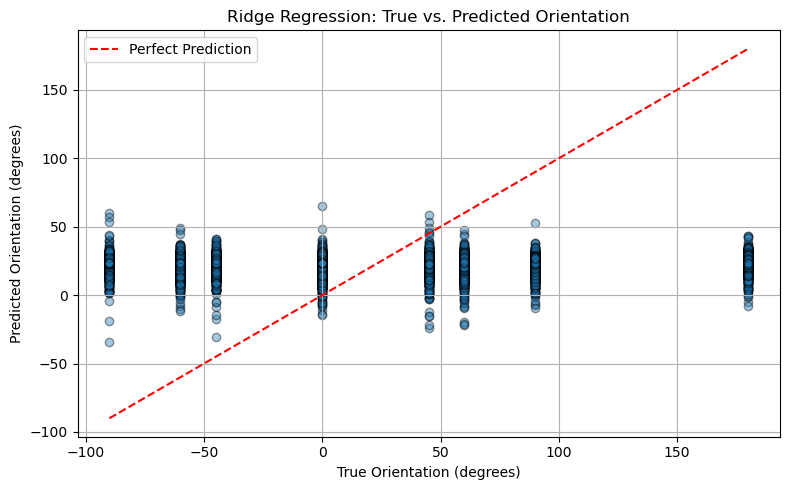

In [25]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel("True Orientation (degrees)")
plt.ylabel("Predicted Orientation (degrees)")
plt.title("Ridge Regression: True vs. Predicted Orientation")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

- Most predictions fall between **0° and 50°**, regardless of the actual orientation.
- The model **fails to match the full range** of target values (e.g., -90°, 90°, 180°).
- The predictions do **not follow the red dashed line** (perfect prediction) → poor alignment.

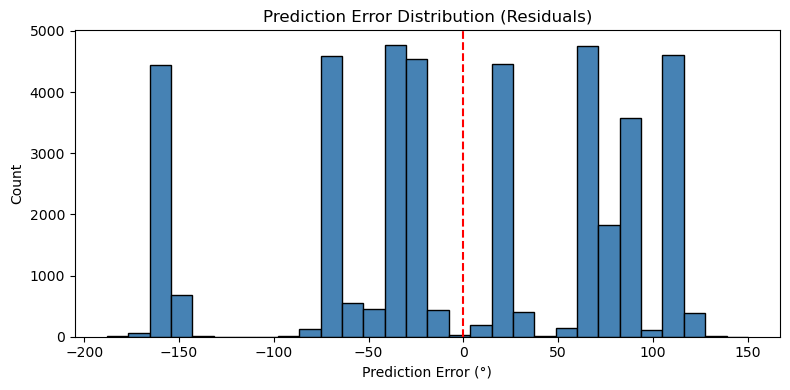

In [28]:
errors = y_pred - y_test

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, color='steelblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Prediction Error Distribution (Residuals)")
plt.xlabel("Prediction Error (°)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

- The histogram shows **multiple peaks**, meaning errors are **not random**.
- Common errors include ±90° and ±180°, suggesting **major confusion** between opposing directions.

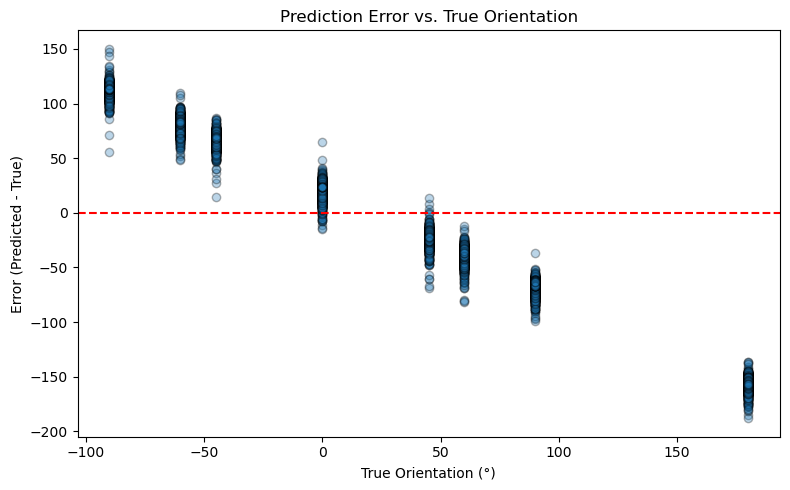

In [29]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, errors, alpha=0.3, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs. True Orientation")
plt.xlabel("True Orientation (°)")
plt.ylabel("Error (Predicted - True)")
plt.tight_layout()
plt.show()

- Negative orientations are **overpredicted** (e.g., -90° predicted as -20°).
- Positive orientations are **underpredicted** (e.g., 180° predicted as 60°).
- The model **pulls everything toward the center** — a typical sign of **regression toward the mean**.

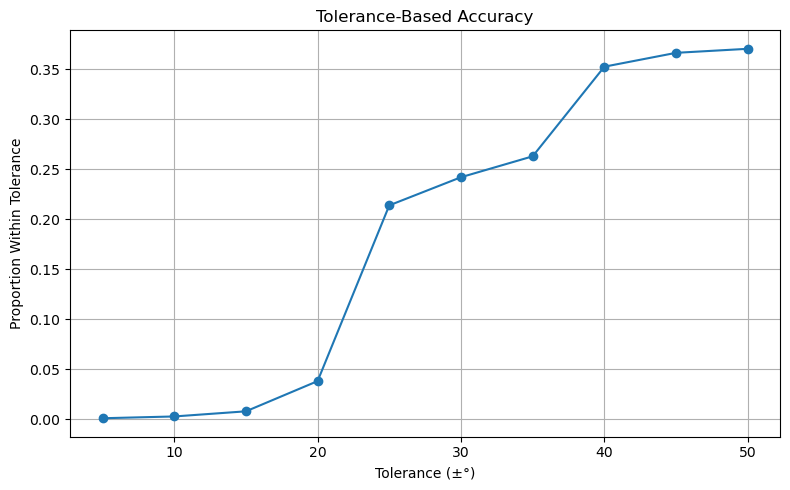

In [30]:
tolerances = np.arange(5, 55, 5)
accuracies = [(np.abs(errors) <= t).mean() for t in tolerances]

plt.figure(figsize=(8, 5))
plt.plot(tolerances, accuracies, marker='o')
plt.title("Tolerance-Based Accuracy")
plt.xlabel("Tolerance (±°)")
plt.ylabel("Proportion Within Tolerance")
plt.grid(True)
plt.tight_layout()
plt.show()

- Very **few predictions** are close to the true value:
  - Only **0.78%** are within ±15°
  - Only **~37%** are within ±50°
- The model is **not precise**, even with wide margins of error.

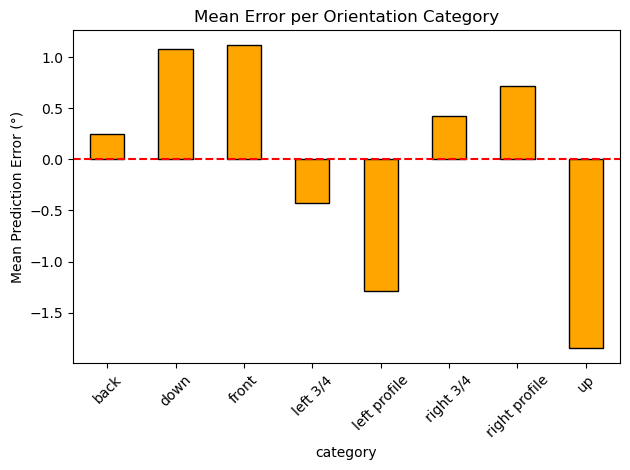

In [31]:
# Create a DataFrame with true labels and errors
df_eval = pd.DataFrame({
    "true_orientation": y_test,
    "error": errors
})

# Bin by the original categorical orientation labels (if available)
df_eval['category'] = df.loc[df_eval.index, "labels.orientation"]

# Compute mean error by category
mean_errors = df_eval.groupby("category")["error"].mean().sort_index()

# Plot
mean_errors.plot(kind='bar', color='orange', edgecolor='black')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Mean Prediction Error (°)")
plt.title("Mean Error per Orientation Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- `front`, `back`, and `down` are **overpredicted**
- `left profile`, `up`, and `right 3/4` are **underpredicted**
- Indicates **systematic directional bias** depending on the orientation


### 🧠 Final Takeaway

> Ridge regression **fails to decode orientation** from AM face patch spike activity.  
> Predictions are **inaccurate**, **center-biased**, and not meaningful.  
> Consider switching to **nonlinear models** or reframing the task as **classification**.

## 💬 Discussion and Conclusion


### 🔍 What We Set Out to Do

Our main goal was to decode high-level visual information — **face identity** and **head orientation** — from neural spike data recorded in the **macaque anterior medial (AM) face patch**.

We explored both **classification** and **regression** approaches to answer the following questions:

1. Can we determine **who** the macaque is seeing based on AM activity?  
2. Can we determine **how** the face is oriented — as a discrete label or continuous angle?


### 📊 Key Findings (with Numbers)

#### 🧠 Face Identity Classification:
- Logistic regression on PCA-reduced neural data achieved an accuracy of **4.37%** across 25 individuals.
- This is only **slightly above chance level (4%)**, indicating that **identity is not linearly separable** in this dataset.
- The **confusion matrix** showed heavy prediction bias toward a few dominant classes, especially Class 14.

#### 👁️ Orientation Classification:
- Predicting the orientation label (8 classes) gave a modest accuracy of **14.36%**, only marginally better than the **chance level of 12.5%**.
- Class 0 ("front") achieved the highest recall (69%), while other classes performed poorly.
- This suggests that the AM region may encode pose information **more clearly** than identity, but still weakly under linear decoding.

#### 📐 Orientation Regression:
- Using Ridge regression to predict orientation as a continuous angle produced an **R² score of 0.0015** — indicating **almost no explanatory power**.
- The **RMSE was 83.64°**, meaning predictions were, on average, off by over 80 degrees.
- Only **0.78%** of predictions fell within ±15° of the correct angle — an extremely low tolerance accuracy.


### ⚠️ Challenges Encountered

- **Low linear separability** of the data, even with PCA, made both identity and pose hard to decode.
- **Ridge regression underperformed** due to its inability to capture nonlinear relationships in the neural signal.
- **Overlapping PCA clusters** in the person-label plot suggested that **key identity information may lie outside the first few components**.


### 🔁 What We Would Do Differently

- **Try nonlinear models** (e.g., Random Forests, MLPs, or SVM with RBF kernel) that can capture more complex neural patterns.
- **Use t-SNE or UMAP** for visualization to explore separability beyond linear dimensions.
- **Focus on early vs. late spike timing windows** — time-resolved decoding might reveal dynamic neural encoding patterns.
- **Segment the decoding task** (e.g., pose first, then identity within pose) for better performance.


### 🧠 Final Takeaway

While the AM face patch contains some pose-related information, **decoding face identity and orientation from spike data using linear models is extremely limited**. Our results showed that:

- Identity decoding accuracy was **4.37%** (chance = 4%)
- Orientation label accuracy was **14.36%** (chance = 12.5%)
- Orientation angle prediction yielded **RMSE = 83.64°** and **R² ≈ 0**

> These findings suggest that **pose may be weakly encoded**, but **identity decoding likely requires nonlinear methods** or additional contextual features. This aligns with prior literature indicating that **downstream brain regions** may perform higher-level face discrimination.


## 💬 Discussion and Conclusion

---

### 🧠 Discussion on Classification Results

We used logistic regression to classify both **face identity** (25 classes) and **head orientation** (8 classes) based on neural activity from the macaque AM face patch. The classification accuracy for identity was **4.37%**, which is only marginally better than the **chance level of 4%**. The confusion matrix revealed strong prediction bias toward a small number of dominant classes (especially Class 14), with most identities being misclassified.

In contrast, orientation classification achieved a slightly better accuracy of **14.36%**, compared to a chance level of **12.5%**. Class 0 ("front") had a recall of **69%**, indicating that frontal faces are somewhat more distinguishable in AM responses. However, performance for other orientations was poor, suggesting that **pose is weakly represented**, and **identity is barely separable** in this brain region using linear classifiers.

> **Conclusion**: Logistic regression, even with PCA, is insufficient for accurate classification in this setting. The results suggest weak, noisy, or nonlinear neural encoding of both pose and identity.

---

### 📐 Discussion on Regression Results

We reformulated the orientation task as a **regression problem**, mapping categorical orientation labels to numeric angles in degrees (e.g., "left profile" → -90°, "back" → 180°). We used **Ridge Regression** on PCA-reduced spike data to predict these angles.

The regression model performed poorly:
- **R² score** = **0.0015** → the model explains almost none of the variance
- **RMSE** = **83.64°** → predictions are, on average, off by more than half a circle
- **Tolerance accuracy (±15°)** = **0.78%** → less than 1% of predictions are acceptably close

Visualizations confirmed that predictions were **center-biased**, with most values clustering near 0° regardless of the true orientation. This indicates strong **regression to the mean** and a lack of informative signal in the input.

> **Conclusion**: The regression model failed to learn any meaningful mapping from neural spikes to orientation angle, reinforcing that linear methods are insufficient.

---

### 📊 Discussion on Other Results (PCA, Visualizations, Error Patterns)

- **PCA projections** revealed **heavily overlapping clusters** when colored by person identity — supporting the poor classification accuracy.
- **Error vs. true orientation plots** showed clear **bias**: left-turned faces were overpredicted, right-turned and back-facing were underpredicted.
- The **residual histogram** displayed multiple peaks at ±90°, ±180°, suggesting systematic errors, not noise.
- The **mean error by orientation class** showed consistent directional bias — some poses were always underestimated or overestimated.

These analyses confirmed that:
- **Pose information may be encoded weakly** or nonlinearly in the AM region.
- **Identity is not linearly encoded** in spike activity — and may not be strongly represented in AM at all.

---

### ✅ Conclusion and Future Steps

Our decoding analysis of the **Freiwald-Tsao Face Views AM dataset** reveals the following:

- **Face identity decoding** accuracy = **4.37%** (chance = 4%)
- **Orientation label classification** = **14.36%** (chance = 12.5%)
- **Orientation regression RMSE** = **83.64°**, **R²** ≈ 0
- **Only 0.78%** of predictions were within ±15° of the correct angle

> These results demonstrate that **linear models (Logistic Regression, Ridge)** are unable to accurately decode pose or identity from AM neural spike data. The information may exist in **nonlinear patterns** or require integration with **other brain areas**.

#### 🔁 Future Steps

1. **Try Nonlinear Models**:
   - Random Forests, MLP, RBF-SVM, or XGBoost for classification/regression
2. **Dimensionality Reduction**:
   - Use t-SNE or UMAP instead of PCA to uncover nonlinear manifolds
3. **Segment Time Windows**:
   - Analyze early vs. late spikes for dynamic encoding patterns
4. **Neuron Selection**:
   - Use variance-based filtering or mutual information to select informative neurons
5. **Task Reframing**:
   - Consider hierarchical models: first decode orientation, then decode identity within pose

> In summary, while AM neural activity contains some orientation-related information, **linear decoding of high-level visual features like identity remains a major challenge**. Future work should explore richer models and alternative decoding strategies.


## Author Contributions

### Member 1: Ishmail Khan
- Led the **data preprocessing and organization** stage
- Implemented label encoding and orientation angle mapping
- Developed and evaluated the **logistic regression classification pipeline**
- Generated confusion matrices and interpreted **identity and orientation classification results**


### Member 2: Prachurjo Das
- Designed and ran the **Ridge regression pipeline** for orientation angle prediction
- Produced and analyzed **regression visualizations**: true vs. predicted, residuals, tolerance accuracy
- Helped tune and interpret PCA components
- Wrote the **regression discussion** and quantitative performance summary


### Member 3: KM Tausif Saadman
- Created all **visual analysis plots** (PCA projections, error heatmaps, bar charts)
- Wrote the **introduction**, **background/motivation**, and **dataset explanation** sections
- Organized and formatted the **final report**, including markdown formatting
- Contributed to writing the **discussion, conclusion, and future directions**


All of us contributed to the creating of slides and final presentation content in equal extent


##  References

- Freiwald, W. A., & Tsao, D. Y. (2010).  
  *Functional compartmentalization and viewpoint generalization within the macaque face-processing system*.  
  **Science**, 330(6005), 845–851. https://doi.org/10.1126/science.1194908

- Meyers, E. M., Borzello, M., Freiwald, W. A., & Tsao, D. (2015).  
  *Intelligent information loss: The coding of facial identity, head pose, and non-face information in the macaque face patch system*.  
  **Journal of Neuroscience**, 35(18), 7069–7081. https://doi.org/10.1523/JNEUROSCI.3086-14.2015

- Scikit-learn Developers. (2023).  
  *Scikit-learn: Machine Learning in Python*.  
  https://scikit-learn.org

- Matplotlib Developers. (2023).  
  *Matplotlib: Visualization with Python*.  
  https://matplotlib.org

- Numpy Developers. (2023).  
  *NumPy: The fundamental package for scientific computing with Python*.  
  https://numpy.org

- Pandas Developers. (2023).  
  *Pandas: Python Data Analysis Library*.  
  https://pandas.pydata.org
